In [1]:
import numpy as np
import time
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.aqua import Operator, run_algorithm

import random
from math import log, pi

In [2]:
# Use Aer's qasm_simulator
backend = Aer.get_backend('qasm_simulator')

In [76]:
# Define layer of quantum circuit.
# For now let's just parameterize the single qubit gates

def rotations(circ, q, n, params):
    for i in range(n):
        circ.u3(params[2*i], params[2*i+1], 0, q[i])

def FC(circ, q, n):
    for i in range(n):
        for j in range(n):
            if i != j:
                circ.cx(q[i], q[j])
                
def layer(circ, q, n, params):
    rotations(circ, q, n, params)
    FC(circ, q, n)
    return circ

In [90]:
# function for creating a target distribution

def get_target():
    d ={
    '0000': 1/8,
    '0110': 1/4,
    '1001': 1/4,
    '0101': 1/8,
    '1010': 1/8,
    '1111': 1/8}
    return d

# def get_target():
#     d ={
#     '000': 1/4,
#     '010': 1/4,
#     '101': 1/4,
#     '111': 1/4  }
#     return d

# define the cost function, here being the KL divergence between the target and learned distributions
def get_cost(target, learned, shots):
    epsilon = 0.01
    cost = 0
    
    for key in learned:
        learned[key] /= shots     # normalize counts from measurements
        
    for key in target:
        if key not in learned:      
            learned[key] = 0         # adds any necessary keys to learned for which we got no counts        
        
        if target[key] != 0:
            cost += target[key]*(log(target[key]) - log(max(epsilon, learned[key])))
    
    return cost

def costFunc(n, params, shots):
  #  params = np.reshape(params, (n,2))
    learned = run_circuit(n, params, shots)
    target = get_target()
    cost = get_cost(target, learned, shots)
    
    return cost

def run_circuit(n, params, shots):
    q = QuantumRegister(n)                  #can these be initialized outside the function?
    c = ClassicalRegister(n)
    circ = QuantumCircuit(q, c)
    
    num_params = len(params)
    num_layers = int(num_params/(2*n))
    
    for k in range(num_layers):
        circ = layer(circ, q, n, params[2*n*k : 2*n*(k+1)])
    
    for i in range(n):
        circ.measure(q[i], c[i])
    result = execute(circ, backend = backend, shots = shots)
    learned = result.result().get_counts(circ)
    
    return learned

def hist(n, params, shots):
    params = np.reshape(params, (n,2))
    learned = run_circuit(n, params, shots)
    plot_histogram(learned)

In [78]:
# Particle swarm optimizer

class Particle:
    def __init__(self,x0):
        self.position_i=[]          # particle position
        self.velocity_i=[]          # particle velocity
        self.pos_best_i=[]          # best position individual
        self.err_best_i=-1          # best error individual
        self.err_i=-1               # error individual

        for i in range(0,num_dimensions):
            self.velocity_i.append(random.uniform(-0.25,0.25))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self, n, costFunc, shots):
        self.err_i=costFunc(n, self.position_i, shots)

        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i
            self.err_best_i=self.err_i

    # update new particle velocity
    def update_velocity(self,pos_best_g):
        w=0.75       # constant inertia weight (how much to weigh the previous velocity)
        c1=2        # cognative constant
        c2=2        # social constant
        
        for i in range(0,num_dimensions):
            r1=random.random()
            r2=random.random()
            
            # We need to account for the fact that parameters are angles
            dist_cog = self.pos_best_i[i]-self.position_i[i]
            if dist_cog > pi:
                dist_cog -= 2*pi
            if dist_cog < -pi:
                dist_cog += 2*pi
                
            dist_soc = pos_best_g[i] - self.position_i[i]
            if dist_soc > pi:
                dist_soc -= 2*pi
            if dist_soc < -pi:
                dist_soc += 2*pi

            vel_cognitive=c1*r1*dist_cog
            vel_social=c2*r2*dist_soc
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    # update the particle position based off new velocity updates
    def update_position(self):
        for i in range(0,num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]

            #account for particles crossing the 0=2pi line
            if self.position_i[i] > 2*pi:
                self.position_i[i] -= 2*pi
            
            if self.position_i[i] < 0:
                self.position_i[i] += 2*pi
    
                
class PSO():
    def __init__(self,n,shots,costFunc,x0,num_particles,maxiter):
        global num_dimensions

        num_dimensions=len(x0)
        self.err_best_g=-1                   # best error for group
        self.pos_best_g=[]                   # best position for group

        # establish the swarm
        swarm=[]
        for i in range(0,num_particles):
            swarm.append(Particle(x0))

        # begin optimization loop
        i=0
        while i < maxiter:
            # cycle through particles in swarm and evaluate fitness
            for j in range(0,num_particles):
                swarm[j].evaluate(n, costFunc, shots)

                # determine if current particle is the best (globally)
                if swarm[j].err_i < self.err_best_g or self.err_best_g == -1:
                    self.pos_best_g=list(swarm[j].position_i)
                    self.err_best_g=float(swarm[j].err_i)

            # cycle through swarm and update velocities and position
            for j in range(0,num_particles):
                swarm[j].update_velocity(self.pos_best_g)
                swarm[j].update_position()
            i+=1
            
            if i%2 == 0:
                print("Iteration %d: %f" % (i, self.err_best_g))

        # print final results
        print('FINAL: %f' % self.err_best_g)
        
    
    def best(self):
        return self.pos_best_g
        

if __name__ == "__PSO__":
    main()

Iteration 2: 1.093338
Iteration 4: 0.740832
Iteration 6: 0.694982
Iteration 8: 0.617123
Iteration 10: 0.607059
Iteration 12: 0.535250
Iteration 14: 0.459520
Iteration 16: 0.349481
Iteration 18: 0.349481
Iteration 20: 0.349481
FINAL: 0.349481


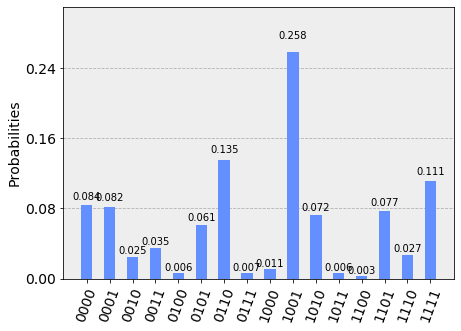

In [91]:
# Run optimization

n = 4
layers = 3
shots = 1000   #shots per run of given circuit; larger will give better statistics from runs

initial = np.random.normal(size=2*n*layers)

best = PSO(n, shots, costFunc, initial, num_particles=40, maxiter=20).best()

learned = run_circuit(n, best, shots)
plot_histogram(learned)

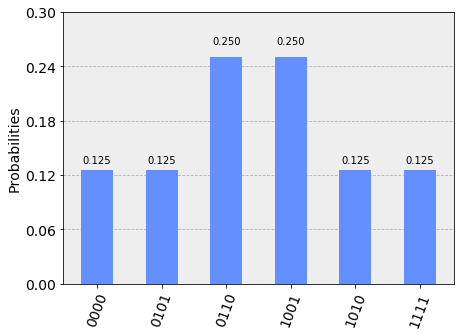

In [88]:
target = get_target()
plot_histogram(target)

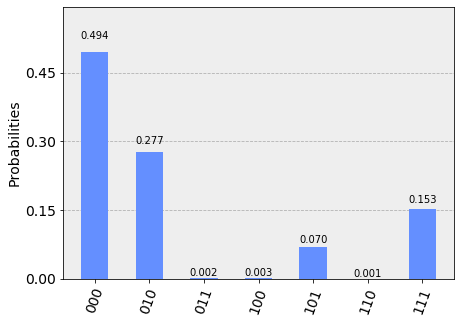

In [81]:
params = [4.952183907076087, 5.366143366803098, 6.1802748069211395, 5.423623009334368, 5.277995751340181, 4.9934647678469295]
learned = run_circuit(n, params, shots)
plot_histogram(learned)

In [61]:
length = len(initial)
layers = int(length/(2*n))
layers

1

In [65]:
n=3
k=0
initial

array([-0.35296714,  1.15942579, -2.63424782, -0.4158417 ,  0.4378306 ,
        1.33024825])

In [68]:
initial[2*n*k : 2*n*(k+1)]

array([-0.35296714,  1.15942579, -2.63424782, -0.4158417 ,  0.4378306 ,
        1.33024825])